In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../../")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [5]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [6]:
class Edge1(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) >= 0.05

In [7]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.add_subdomain(Middle(), 1)
        self.add_subdomain(Edge1(), 2)
        self.add_subdomain(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        sd = self.mesh.sd
        left = numpy.sum(vol[sd == 2])
        right = numpy.sum(vol[sd == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [8]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [9]:
model.listOfReactions

OrderedDict([('rxn32d21372_ee01_4ffb_a7cf_f6b809fa3c95',
              <spatialpy.Model.Reaction at 0x7fa331b56c40>),
             ('rxnf7c6833c_aa54_4932_a620_6ce9b7653233',
              <spatialpy.Model.Reaction at 0x7fa331b56b50>),
             ('rxn49ee98ad_d94d_4237_9c13_85d73c2c7a64',
              <spatialpy.Model.Reaction at 0x7fa331b56d60>)])

In [10]:
from spatialpy.nsmsolver import NSMSolver

In [11]:
#result = model.run(debug_level=2)
sol = NSMSolver(model, debug_level=2)
sol.h = 0.8
print("h="+str(sol.h))
%time sol.compile()

h=0.8
Compiling Solver.  Build dir: /tmp/spatialpy_build_8fe1_eef
Creating propensity file /tmp/spatialpy_build_8fe1_eef/cylinder_demo3d_generated_model.c
cmd: cd /tmp/spatialpy_build_8fe1_eef ; make -f /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile.nsm ROOT=/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/spatialpy_build_8fe1_eef/cylinder_demo3d_generated_model.c BUILD=/tmp/spatialpy_build_8fe1_eef

gcc -c -o linked_list.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o particle.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o simulate.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/simulate.c -I/home/mason/Proj

In [12]:
%time result = sol.run()

cmd: cd /tmp/spatialpy_result_4wtjaq_c;/tmp/spatialpy_build_8fe1_eef/ssa_sdpd

Elapsed seconds: 1.08

CPU times: user 0 ns, sys: 5.39 ms, total: 5.39 ms
Wall time: 1.08 s


50164.0
49811.0
0.5092013833059308
0.505804729089437


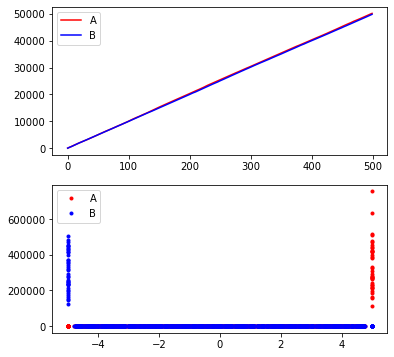

In [13]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
sd = model.mesh.sd
print(numpy.sum(vol[sd == 2]))
print(numpy.sum(vol[sd == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')
